# Dagger Workshop - JuliaCon 2024
Presenters:
- Julian Samaroo (MIT JuliaLab)
- Prof. Przemyslaw Szufel (SGH Warsaw)

### Why have this workshop?

- Users want easy parallelism, library authors want composable parallelism
- It's easy to do multithreading *OR* distributed *OR* GPU - why not all 3 at once?
- Dagger can provide all of this, but how can we use it to achieve our goals?

### Workshop Overview

- What's available today without Dagger?
  - Intro to Task-based computing, Multithreading, Distributed, and Julia's parallelism utilities
  - Dagger Task-Based computing
  - Task-based parallelism paradigms
  - DArrays (Dagger's Distributed Arrays)
  - Datadeps (Dagger's Data Dependencies system)
  - Short break!
  - TODO

# Multitasking, Multithreading, and Distributed

### TODO

In [ ]:
using Distributed

# If no threads are enabled (no problem!), let's create some Julia worker processes instead
if Threads.nthreads() == 1
    addprocs(;exeflags="--project=$(pwd())")
end

# Tasks with Dagger

### TODO

# DArrays

# Datadeps

In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `/mnt/alpine/home/jpsamaroo/docs/JuliaCon/2024`


In [3]:
using Dagger

# Don't mind the warnings, this is because IJulia also exports `In` and `Out`

## Vector Sum

In [4]:
# Allocate a regular `Vector`, and distribute it as a `DVector` (which is a `DArray`)
A = rand(1_000_000)
DA = DVector(A)

DVector{Float64}(1000000,) with 6 partitions of size 166667:
~0% completed
 0.630415
 0.890706
 0.623566
 0.951655
 0.986168
 0.0116873
 0.760279
 0.143378
 0.282888
 0.130412
 0.492957
 0.836954
 0.62852
 ⋮
 0.834028
 0.351306
 0.164716
 0.0276749
 0.838686
 0.672299
 0.779465
 0.310573
 0.704037
 0.550145
 0.410708
 0.180047

In [5]:
# How many chunks does `DA` have? This is relevant to Datadeps
length(DA.chunks)

6

In [6]:
# We need to sum the array - but how?
# Let's sum our partitions individually first
for part in DA.chunks
    @show fetch(Dagger.@spawn sum(part))
end

fetch(#= In[6]:4 =# Dagger.@spawn(sum(part))) = 83267.71399335064
fetch(#= In[6]:4 =# Dagger.@spawn(sum(part))) = 82878.6023471829
fetch(#= In[6]:4 =# Dagger.@spawn(sum(part))) = 83277.42967536501
fetch(#= In[6]:4 =# Dagger.@spawn(sum(part))) = 83238.09212882377
fetch(#= In[6]:4 =# Dagger.@spawn(sum(part))) = 83456.67805391495
fetch(#= In[6]:4 =# Dagger.@spawn(sum(part))) = 83243.20042383892


In [7]:
# Ok, we can sum partitions - now let's tie this together, with Datadeps!
# We need to store our partial sums somewhere, so we'll allocate a temporary array

function datadeps_sum(DA::DVector)
    # Allocate a temporary output `Vector`, with the same number of elements as
    # the number of partitions in `DA`
    nchunks = length(DA.chunks)
    temp = zeros(Float64, nchunks)
    
    # Use `spawn_datadeps` to start a Datadeps region
    return fetch(Dagger.spawn_datadeps() do
        # For each partition of `DA`, sum it and write the result into the
        # corresponding slot of `temp`
        for (idx, part) in enumerate(DA.chunks)
            temp_view = view(temp, idx:idx)
            # Specify to Datadeps that `temp_view` is written to by this task
            Dagger.@spawn sum!(Dagger.Out(temp_view), part)
        end
    
        # Finally, calculate and return the sum of `temp`, which is the sum of `DA`
        Dagger.@spawn sum(temp)
    end)
end

datadeps_sum (generic function with 1 method)

In [8]:
# Same result, but more parallel!
result = datadeps_sum(DA)
@show result
@assert result ≈ sum(A)

result = 499361.71662247623


## Cholesky Factorization

In [9]:
using LinearAlgebra

In [36]:
C = rand(4096, 4096)
C = C * C'
C[diagind(C)] .+ 100.0
@assert isposdef(C)
DC = DArray(C, Blocks(512, 512))

function datadeps_cholesky!(DC)
    uplo = 'U'
    zone = 1.0
    mzone = -1.0
    Cc = DC.chunks
    mt, nt = size(Cc)
    trans = 'T'
    
    # Upper-triangular Cholesky
    Profile.clear()
    Profile.@profile Dagger.spawn_datadeps() do
        for k in range(1, mt)
            Dagger.@spawn LAPACK.potrf!(uplo, Dagger.InOut(Cc[k, k]))
            for n in range(k+1, nt)
                Dagger.@spawn BLAS.trsm!('L', uplo, trans, 'N', zone, Dagger.In(Cc[k, k]), Dagger.InOut(Cc[k, n]))
            end
            for m in range(k+1, mt)
                Dagger.@spawn BLAS.syrk!(uplo, 'T', mzone, Dagger.In(Cc[k, m]), zone, Dagger.InOut(Cc[m, m]))
                for n in range(m+1, nt)
                    Dagger.@spawn BLAS.gemm!(trans, 'N', mzone, Dagger.In(Cc[k, m]), Dagger.In(Cc[k, n]), zone, Dagger.InOut(Cc[m, n]))
                end
            end
        end
    end

    return UpperTriangular(DC)
end
DA = datadeps_cholesky!(fetch(copy(DC)))
@assert DA ≈ cholesky(C).U

In [11]:
using GraphViz
using Plots, DataFrames

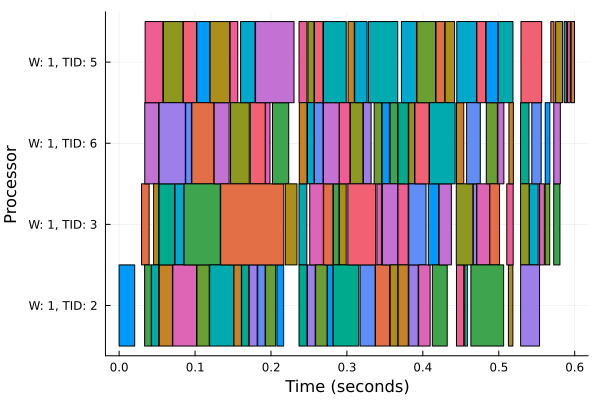

In [37]:
_DC = fetch(copy(DC))
Dagger.enable_logging!(;metrics=false)
datadeps_cholesky!(_DC)
logs = Dagger.fetch_logs!()
Dagger.disable_logging!()

Dagger.render_logs(logs, :plots_gantt)

In [14]:
using Profile

In [38]:
Profile.print(;mincount=2, groupby=:thread)

Overhead ╎ [+additional indent] Count File:Line; Function
Thread 1 Total snapshots: 118. Utilization: 21%
  ╎29  @Base/task.jl:675; task_done_hook(t::Task)
  ╎ 29  @Base/task.jl:994; wait()
29╎  29  @Base/task.jl:985; poptask(W::Base.IntrusiveLinkedListSynchronized{Tas…
  ╎32  @Dagger/src/sch/Sch.jl:1197; #138
  ╎ 32  @Base/lock.jl:457; wait(e::Base.Event)
  ╎  32  @Base/condition.jl:125; wait
  ╎   32  @Base/condition.jl:130; wait(c::Base.GenericCondition{ReentrantLock};…
  ╎    32  @Base/task.jl:994; wait()
32╎     32  @Base/task.jl:985; poptask(W::Base.IntrusiveLinkedListSynchronized{…
  ╎35  @Dagger/src/sch/util.jl:9; #1
  ╎ 35  @Base/task.jl:350; wait
  ╎  35  @Base/task.jl:310; _wait(t::Task)
  ╎   35  @Base/condition.jl:125; wait
  ╎    35  @Base/condition.jl:130; wait(c::Base.GenericCondition{Base.Threads.S…
  ╎     35  @Base/task.jl:994; wait()
35╎    ╎ 35  @Base/task.jl:985; poptask(W::Base.IntrusiveLinkedListSynchronized…
  ╎20  …Julia/src/eventloop.jl:38; (::IJulia.var"#15#

┌ Warning: There were no samples collected in one or more groups.
│ This may be due to idle threads, or you may need to run your
│ program longer (perhaps by running it multiple times),
│ or adjust the delay between samples with `Profile.init()`.
└ @ Profile /mnt/alpine/home/jpsamaroo/.julia/juliaup/julia-1.10.3+0.x64.linux.gnu/share/julia/stdlib/v1.10/Profile/src/Profile.jl:1208
